In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy as cp
sns.set_theme()

np.random.seed(1)

## Exercise 2

#### activations, losses, gradients

In [2]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def mse_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/len(y_true)

#### main neural network class

In [3]:
class NeuralNetwork:
    
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self.activations = []
        self.activation_derivatives = []
        self.weights_gradients = []
        self.biases_gradients = []
        self.loss = mse
        self.loss_derivative = mse_derivative
        self.L = len(layer_sizes)
        self.initialize_weights()
        
    
    def initialize_weights(self):
        last_size = self.layer_sizes[0]
        
        for l in range(1,self.L):
            this_size = self.layer_sizes[l]
            
            # weights
            self.weights.append(self.glorot_initialization(last_size, this_size))
            
            #biases
            self.biases.append(np.zeros((this_size,1)))
            
            #activations
            self.activations.append(np.tanh)
            self.activation_derivatives.append(tanh_derivative)
            
            last_size = this_size
            
    @staticmethod
    def glorot_initialization(last_size, this_size):
        b = np.sqrt(6/(this_size+last_size))
        return np.random.uniform(-b, b,(last_size, this_size))
        
    def predict(self, x):
        if isinstance(x, pd.DataFrame):
            x = x.values
        z_out = x
        for l in range(self.L-1):
            z_in = ((z_out @ self.weights[l]).T + self.biases[l]).T
            z_out = self.activations[l](z_in)
        return z_out
        
    def gradient(self, x, y):
        if isinstance(x, pd.DataFrame):
            x = x.values
        if isinstance(y, pd.DataFrame):
            y = y.values
            
        activations = [x]
        pre_activations = [x]
        
        for l in range(self.L-1):
            z_in = ((activations[l] @ self.weights[l]).T + self.biases[l]).T
            z_out = self.activations[l](z_in)
            pre_activations.append(z_in)
            activations.append(z_out)
            
        loss = self.loss(y,activations[-1])  
        
        self.weights_gradients = [None] * (self.L-1)
        self.biases_gradients = [None] * (self.L-1)
        
        deltas = self.loss_derivative(y, activations[-1])*self.activation_derivatives[-1](pre_activations[-1])

        for l in reversed(range(len(self.layer_sizes)-1)):
            self.weights_gradients[l] = (activations[l]).T @ deltas
            self.biases_gradients[l] = deltas.sum(axis=0).reshape(-1,1)


            if l > 0:
                deltas = deltas @ (self.weights[l]).T *self.activation_derivatives[l-1](pre_activations[l])

            assert self.weights[l].shape == self.weights_gradients[l].shape
            assert self.biases[l].shape == self.biases_gradients[l].shape
        
            
        return loss
    
    def gradient_descent_step(self, learning_rate):
        for l in range(self.L-1):
            self.weights[l] = self.weights[l] - learning_rate * self.weights_gradients[l]
            self.biases[l] = self.biases[l] - learning_rate * self.biases_gradients[l]


    def train(self, x, y, n_epochs, learning_rate):
        losses = []

        for e in range(n_epochs):
            loss = self.gradient(x,y)
            self.gradient_descent_step(learning_rate)
            losses.append(loss)

        return losses

In [4]:
def get_plot_data():
    x_grid, y_grid = np.mgrid[-2:2:1/25, -2:2:1/25]
    x_pos = x_grid.ravel()
    y_pos = y_grid.ravel()
    return pd.DataFrame(data=np.array([x_pos,y_pos]).T, columns=['x1','x2'])

def plot_grid(predictions):
    plt.figure()
    sns.scatterplot(x=grid.x1,y=grid.x2, hue=predictions, marker="s",s=11)
    sns.scatterplot(x=train_data.x1,y=train_data.x2, hue=train_data.y, marker="s",s=20)
    plt.show()
    
grid = get_plot_data()
train_data = pd.DataFrame(data=np.array([[0,1,0,-1,0],[0,0,-1,0,1],[1,0,0,0,0]]).T, columns=['x1','x2','y'] )

#### randomly initialzed network

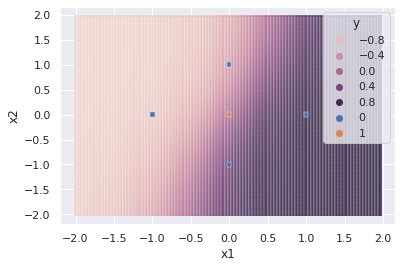

In [5]:
nnet = NeuralNetwork((2,5,3,1))
plot_grid(nnet.predict(grid).flatten())

#### training the network on the data set

In [6]:
nnet = NeuralNetwork((2,5,3,1))
losses = nnet.train(train_data[["x1","x2"]], train_data[['y']],2000,0.25)

#### evaluation

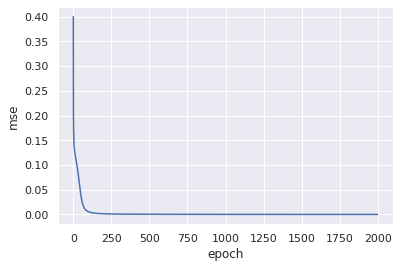

In [7]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

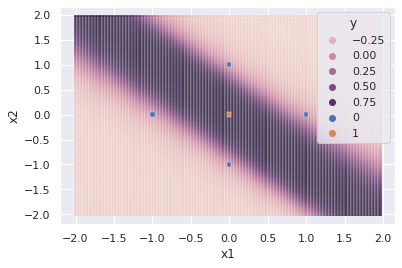

In [8]:
plot_grid(nnet.predict(grid).flatten())